# NPL on Yelp Open Dataset for Review Classification

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import langdetect as ld

pd.options.display.float_format = "{:,.2f}".format

## Data Loading

The Open Yelp Review Dataset contains more than a million of entries. To load them in a panda dataframe, we use chunking method to divide and load faster data and dropping not relevant columns in the final result.

I didn't considered correlation between reviews for a same shop/restaurant.

In [35]:
df_rev = []
df_bus = []

b_dtypes = {"stars" : np.float16,}

r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }



In [36]:
%%time 
with open("yelp_academic_dataset_review.json", "r") as dataset:
    reader = pd.read_json(dataset, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=10000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id'])
        df_rev.append(reduced_chunk)
    
df_rev = pd.concat(df_rev, ignore_index=True)

CPU times: user 1min 32s, sys: 19.8 s, total: 1min 51s
Wall time: 1min 54s


In [37]:
%%time 
with open("yelp_academic_dataset_business.json", "r") as _dataset:
    b_reader = pd.read_json(_dataset, orient="records", lines=True, dtype=b_dtypes, chunksize=10000)
    
    for chunk in b_reader:
        reduced_bchunk = chunk.drop(columns=['name', 'address', 'city','postal_code', 'state', 'latitude', 'longitude'
                                            , 'attributes', 'categories', 'hours'])
        df_bus.append(reduced_bchunk)
    
df_bus = pd.concat(df_bus, ignore_index=True)

CPU times: user 2.84 s, sys: 262 ms, total: 3.11 s
Wall time: 3.17 s


In [38]:
df_bus.head()

,business_id,stars,review_count,is_open
0,6iYb2HFDywm3zjuRg0shjw,4.00,86,1
1,tCbdrRPZA0oiIYSmHG3J0w,4.00,126,1
2,bvN78flM8NLprQ1a1y5dRg,4.50,13,1
3,oaepsyvc0J17qwi8cfrOWg,3.00,8,1
4,PE9uqAjdw0E4-8mjGl3wVA,4.00,14,1


In [39]:
df_rev.head()

,business_id,stars,useful,funny,cool,text,date
0,buF9druCkbuXLX526sGELQ,4.00,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,RA4V8pr014UyUbDvI-LW2A,4.00,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,_sS2LBIGNT5NQb6PD1Vtjw,5.00,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,0AzLzHfOJgL7ROwhdww2ew,2.00,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,8zehGz9jnxPqXtOc7KaJxA,4.00,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


## Data Analysis 

In [40]:
# show head dataframe
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   business_id  object        
 1   stars        float16       
 2   useful       int32         
 3   funny        int32         
 4   cool         int32         
 5   text         object        
 6   date         datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(2)
memory usage: 312.9+ MB


In [41]:
df_rev.describe()

,stars,useful,funny,cool
count,"8,635,403.00","8,635,403.00","8,635,403.00","8,635,403.00"
mean,NaN,1.25,0.42,0.50
std,0.00,3.20,1.87,2.24
min,1.00,0.00,0.00,0.00
25%,3.00,0.00,0.00,0.00
50%,4.00,0.00,0.00,0.00
75%,5.00,1.00,0.00,0.00
max,5.00,758.00,610.00,732.00


In [42]:
# Adding a text length for the text and stars correlation
df_rev['text length'] = df_rev['text'].apply(len)

In [43]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   business_id  object        
 1   stars        float16       
 2   useful       int32         
 3   funny        int32         
 4   cool         int32         
 5   text         object        
 6   date         datetime64[ns]
 7   text length  int64         
dtypes: datetime64[ns](1), float16(1), int32(3), int64(1), object(2)
memory usage: 378.8+ MB


In [44]:
df_rev.head()

,business_id,stars,useful,funny,cool,text,date,text length
0,buF9druCkbuXLX526sGELQ,4.00,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,1856
1,RA4V8pr014UyUbDvI-LW2A,4.00,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,701
2,_sS2LBIGNT5NQb6PD1Vtjw,5.00,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,578
3,0AzLzHfOJgL7ROwhdww2ew,2.00,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,390
4,8zehGz9jnxPqXtOc7KaJxA,4.00,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,181


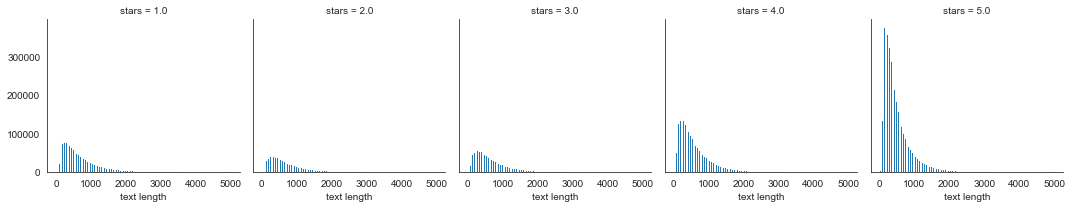

In [45]:
sns.set_style('white')
g1 = sns.FacetGrid(df_rev, col='stars')
g1.map(plt.hist, 'text length', bins=100)

Text length is for the most cases between 0 and 1000 words, every plot has some outliers


<AxesSubplot:xlabel='stars', ylabel='text length'>

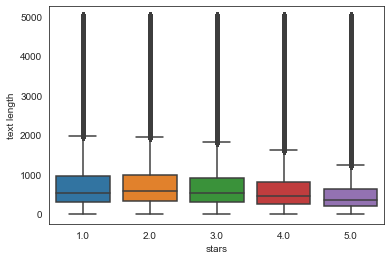

In [46]:
sns.boxplot(x='stars', y='text length', data=df_rev)

The text length median and number of outliers decreases in according to the stars increment. So, negative reviews have, in general, a text length longer than positive one.

<AxesSubplot:>

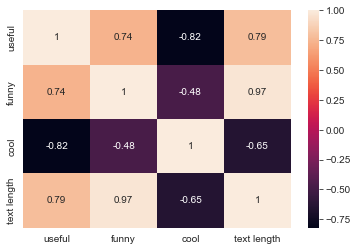

In [47]:
# Showing the heatmap to display possible correlation between text length and stars evaluation
sns.heatmap(df_rev.groupby('stars').mean().corr(), annot=True)

There are some correlations between funny and useful values and the drift to write long texts.

<AxesSubplot:xlabel='stars', ylabel='count'>

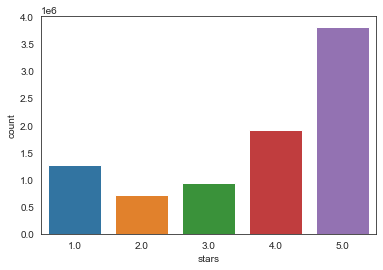

In [48]:
sns.countplot(x='stars', data=df_rev)

Dataset is unbalanced, the amount of reviews for every level of stars is different.

<AxesSubplot:xlabel='stars', ylabel='count'>

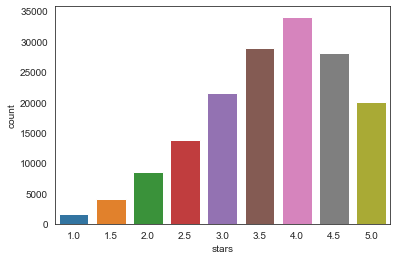

In [49]:
sns.countplot(x='stars', data=df_bus)

Most of business have a good stars evaluation with a maximum counting on 4.0

In [50]:
agg_funct = {'stars': 'mean', 'cool': 'mean','funny' : 'mean', 'useful' : 'mean'}
df_agg = df_rev.groupby(df_rev['business_id']).aggregate(agg_funct)

In [51]:
df_agg.head()

,stars,cool,funny,useful
business_id,,,,
--0DF12EMHYI8XIgoFha6A,4.33,0.00,0.00,0.50
--0r8K_AQ4FZfLsX3ZYRDA,5.00,0.20,0.00,0.40
--0zrn43LEaB4jUWTQH_Bg,1.00,0.67,0.67,2.33
--164t1nclzzmca7eDiJMw,3.88,1.41,1.36,1.85
--2aF9NhXnNVpDV0KS3xBQ,2.55,0.33,0.11,0.44


<AxesSubplot:>

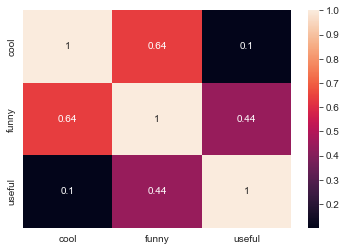

In [52]:
# heatmap for funny, cool and useful mean values with stars evaluation for single business
sns.heatmap(df_agg.groupby('stars').mean().corr(), annot=True)

## Data Preprocessing

First of all, we need to divide the reviews between positive and negative one.

In [53]:
df_rev.head()

,business_id,stars,useful,funny,cool,text,date,text length
0,buF9druCkbuXLX526sGELQ,4.00,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,1856
1,RA4V8pr014UyUbDvI-LW2A,4.00,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,701
2,_sS2LBIGNT5NQb6PD1Vtjw,5.00,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,578
3,0AzLzHfOJgL7ROwhdww2ew,2.00,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,390
4,8zehGz9jnxPqXtOc7KaJxA,4.00,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,181


In [54]:
# check if df_rev has NaN values
df_rev.isnull().values.any()

False

In [55]:
# check if df_bus has NaN values
df_bus.isnull().values.any()

False

In [75]:
# bin_split
# tokenize 

69083224

## Data Modelling

In [58]:
X = df_rev['text']
Y = df_rev['stars']

cv = CountVectorizer()
X = cv.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)


KeyboardInterrupt: 

In [ ]:
# Multinomial NB
nb = MultinomialNB()


In [ ]:
nb.fit(X_train, Y_train)

In [ ]:
model = nb.predict(X_test)

## Results

In [ ]:
print(confusion_matrix(Y_test, model))
print('/n')
print(classification_report(Y_test, model))